In [15]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
import datetime
from collections import defaultdict, Counter
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)

In [16]:
n_simulations = 1000
#path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/monte_carlo_networks/network_'
#path = 'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/solstorm_3_mc_networks/network_'
path = '/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/network_'
#networks = [pypsa.Network(path + str(i) + '.nc') for i in range(1,n_simulations+1)]
teal3 = '#527D77'
price_LL = 22000

In [17]:
# Helper functions

def get_snapshot_generation(network, first_date, second_date, carrier):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].groupby(network.storage_units.carrier, axis=1).sum()[carrier]
    elif carrier == 'battery' or carrier == 'H2':
        generation = network.stores_t.p.loc[first_date:second_date].groupby(network.stores.carrier, axis=1).sum()[carrier]
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)
    return demand

def calculate_lost_load(network, first_date="2013-01-01", second_date="2013-12-31"):
    CCGT = get_snapshot_generation(network, first_date, second_date, 'CCGT')
    OCGT = get_snapshot_generation(network, first_date, second_date, 'OCGT')
    Oil = get_snapshot_generation(network, first_date, second_date, 'oil')
    Geothermal = get_snapshot_generation(network, first_date, second_date, 'geothermal')
    Hydro = get_snapshot_generation(network, first_date, second_date, 'ror') + get_snapshot_generation(network, first_date, second_date, 'hydro')
    Wind = get_snapshot_generation(network, first_date, second_date, 'onwind')
    Solar = get_snapshot_generation(network, first_date, second_date, 'solar')
    Biomass = get_snapshot_generation(network, first_date, second_date, 'biomass')
    Battery = get_snapshot_generation(network, first_date, second_date, 'battery')
    demand = get_snapshot_demand(network, first_date, second_date)

    nbattery = [(i*-1) if i < 0 else 0 for i in Battery]
    pbattery = [i if i > 0 else 0 for i in Battery]

    nbattery_9 = [float(n) / 0.9 for n in nbattery]
    pbattery_9 = [float(n) * 0.9 for n in pbattery]

    LL = (demand.values + nbattery_9) - (CCGT + OCGT + Oil + Wind + Solar + Biomass + Hydro + pbattery_9 + Geothermal)
    return LL

def load_matrices(iteration):
    #df_lines = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/lines_matrix_{iteration}.csv')
    df_lines = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/lines_matrix_{iteration}.csv')
    #df_generators = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/generators_matrix_{iteration}.csv')
    df_generators = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/generators_matrix_{iteration}.csv')
    #df_storage_units = pd.read_csv(f'C:/Users/noraky/Documents/Masteroppgave/pypsa-earth/matrices/storage_units_matrix_{iteration}.csv')
    df_storage_units = pd.read_csv(f'/mnt/beegfs/users/noraky/pypsa-earth/monte_carlo_networks/storage_units_matrix_{iteration}.csv')
    
    # Assuming the datetime column is named 'datetime' and is the first column
    datetime_column = df_generators['datetime']

    # Drop the datetime column for concatenation
    df_generators = df_generators.drop(columns=['datetime'])
    df_lines = df_lines.drop(columns=['datetime'])
    df_storage_units = df_storage_units.drop(columns=['datetime'])
    
    # Concatenate the dataframes horizontally
    states_df = pd.concat([df_lines, df_generators, df_storage_units], axis=1)
    
    # Reinsert the datetime column at the beginning
    states_df.insert(0, 'datetime', datetime_column)
    
    return states_df

def get_top_lost_load_hours(all_LL_values, top_n_hours=100):
    all_LL_df = pd.DataFrame(all_LL_values, columns=['Lost_Load', 'Simulation', 'Hour', 'Datetime'])
    top_hours_df = all_LL_df.nlargest(top_n_hours, 'Lost_Load').reset_index(drop=True)
    return top_hours_df

def analyze_top_hours(top_hours_df):
    results = []
    for idx, row in top_hours_df.iterrows():
        iteration = int(row['Simulation'])
        hour = int(row['Hour'])
        datetime_value = row['Datetime']
        lost_load = row['Lost_Load']
        rank = idx + 1  # One-based ranking

        # Load the state matrices for the specific iteration
        states_df = load_matrices(iteration)
        states_at_hour = states_df.iloc[hour, 1:]  # Skip datetime column
        failed_components = states_at_hour[states_at_hour == 0].index.tolist()
        results.append([rank, iteration, datetime_value, lost_load, failed_components])

    return results

def analyze_lost_loads(all_LL_values, state_matrices):
    component_caused_ll = defaultdict(list)
    multiple_components_caused_ll = defaultdict(list)

    for ll, iteration, hour, datetime_value in all_LL_values:
        if ll > 1:
            states_df = state_matrices[iteration]
            states_at_hour = states_df.iloc[hour, 1:]  # Skip datetime column
            failed_components = states_at_hour[states_at_hour == 0].index.tolist()

            if len(failed_components) == 1:
                component = failed_components[0]
                component_caused_ll[component].append(ll)
            else:
                multiple_components_caused_ll[tuple(failed_components)].append(ll)

    return component_caused_ll, multiple_components_caused_ll


def calculate_LL_occurence(LL):
    time_LL = 0
    for i in LL:
        if i > 1:
            time_LL += 1
    return time_LL

def get_indices():
    #n = pypsa.Network('../network_bnze_2040/BNZE_2040.nc')
    n = pypsa.Network('/mnt/beegfs/users/noraky/pypsa-earth/network_bnze_2040/BNZE_2040.nc')
    line_indices = list(n.lines.index)
    generators = n.generators[~n.generators.carrier.str.contains('load')].carrier.unique()
    generator_indices = []
    for carrier in generators:
        generator_indices += list(n.generators.query(f"carrier == '{carrier}'").index)
    storage_unit_indices = list(n.storage_units.index)
    all_indices = line_indices + generator_indices + storage_unit_indices
    return all_indices

def total_ll_node(network,loads):
    LL = network.generators_t.p[loads].sum()
    return LL / 1e3 # MWh

def time_ll_node(network, loads):
    LL = network.generators_t.p[loads] / 1e3  # Convert to MWh
    time_LL = pd.DataFrame(0, index=loads, columns=['Times Load Loss'])
    for load in loads:
        time_LL.loc[load, 'Times Load Loss'] = calculate_LL_occurence(LL[load])
    return time_LL
    
    


In [18]:
total_LL = 0
time_LL = 0
LL_values = []
LL_ranges = {}
n_Hr = 8760
all_LL_values = []
first_date = datetime.datetime(2013, 1, 1)
loads_indices = pypsa.Network(path + '1.nc').generators.query('carrier == "load"').index
total_nodal_LL = pd.DataFrame(0, index=loads_indices, columns=['Total Load Loss'])
times_nodal_LL = pd.DataFrame(0, index=loads_indices, columns=['Times Load Loss'])

for iteration in range(1,n_simulations+1):
    network = pypsa.Network(path + str(iteration) + '.nc')
    LL = calculate_lost_load(network)

    for hour in range(n_Hr):
        datetime_value = first_date + datetime.timedelta(hours=hour)
        all_LL_values.append([max(0,LL[hour]), iteration, hour, datetime_value])

    time_LL += calculate_LL_occurence(LL)

    current_LL = 0
    for i in LL:
        current_LL += max(0, i)
    print('LL ' + str(iteration) + ': ', current_LL/1e3)
    LL_values.append(current_LL/1e3)

    #LL per node
    nodal_LL = total_ll_node(network,loads_indices)
    total_nodal_LL['Total Load Loss'] += nodal_LL
    nodal_times_LL = time_ll_node(network, loads_indices)
    times_nodal_LL['Times Load Loss'] += nodal_times_LL['Times Load Loss']

LL 1:  118.18537719968243
LL 2:  173.2639153322789
LL 3:  191.8149028834539
LL 4:  196.10409180350547
LL 5:  157.841805643129
LL 6:  147.56705153035526
LL 7:  131.19939449170587
LL 8:  159.12841363737363
LL 9:  147.0361738607552
LL 10:  187.58917274721605
LL 11:  121.38998086923462
LL 12:  146.37987434935
LL 13:  131.23591085545303
LL 14:  162.36604422214666
LL 15:  134.34320012683398
LL 16:  153.1141698016953
LL 17:  167.74282234754637
LL 18:  119.00785019532682
LL 19:  183.80155492583725
LL 20:  123.47742212150385


In [19]:
state_matrices = {}

for iteration in range(1, n_simulations + 1):
    state_matrices[iteration] = load_matrices(iteration)

# Analyze all lost load occurrences
component_caused_ll, multiple_components_caused_ll = analyze_lost_loads(all_LL_values, state_matrices)

# Calculate average lost load caused by single component failures
avg_component_caused_ll = {component: np.mean(losses) for component, losses in component_caused_ll.items()}

# Calculate average lost load caused by multiple component failures
avg_multiple_components_caused_ll = {components: (np.mean(losses), len(losses)) for components, losses in multiple_components_caused_ll.items()}

# Create a DataFrame for the average lost load caused by single component failures
avg_component_caused_ll_df = pd.DataFrame(list(avg_component_caused_ll.items()), columns=['Component', 'Average Lost Load'])

# Create a DataFrame for the average lost load caused by multiple component failures
avg_multiple_components_caused_ll_df = pd.DataFrame([(components, avg_loss, occurrences) for components, (avg_loss, occurrences) in avg_multiple_components_caused_ll.items()], columns=['Components', 'Average Lost Load', 'Occurrences'])

time_LL_df = pd.DataFrame([time_LL], columns=['Time LL'])
time_LL_df.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/time_LL.csv', index=False)

LL_df = pd.DataFrame(LL_values, columns=["LL Values"])
LL_df.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/LL_values.csv', index=False)

# Save the results to CSV files
avg_component_caused_ll_df.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/avg_component_caused_ll.csv', index=False)
avg_component_caused_ll_df.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/avg_component_caused_ll.csv', index=False)
avg_multiple_components_caused_ll_df.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/avg_multiple_components_caused_ll.csv', index=False)
total_nodal_LL.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/total_nodal_LL.csv')
times_nodal_LL.to_csv('/mnt/beegfs/users/noraky/pypsa-earth/csa_results/times_nodal_LL.csv')

print("Results saved to csv files")

Results saved to 'avg_component_caused_ll.csv' and 'avg_multiple_components_caused_ll.csv'


In [ ]:
# LL_ranges = {}
# for ll_value in LL_values:
#     # Define range by floor division, multiplying by 10 for range start and end
#     lower_bound = int(ll_value // 10 * 10)
#     upper_bound = lower_bound + 9  # Define upper bound consistently

#     # Create a consistently formatted range key
#     range_key = f"{lower_bound} - {upper_bound}"

#     # Increment the count for this range in the dictionary
#     if range_key in LL_ranges:
#         LL_ranges[range_key] += 1
#     else:
#         LL_ranges[range_key] = 1
    
#     # lower_bound = int(ll_value)  # Whole number floor
#     # upper_bound = lower_bound + 10
#     # range_key = f"{lower_bound} - {upper_bound - 1}"
#     # if range_key in LL_ranges:
#     #     LL_ranges[range_key] += 10
#     # else:
#     #     LL_ranges[range_key] = 10
# min_value = int(min(LL_values))
# max_value = int(max(LL_values))


# all_ranges = []
# for lower_bound in range(min_value // 10 * 10, (max_value // 10 + 1) * 10, 10):
#     upper_bound = lower_bound + 9
#     range_key = f"{lower_bound} - {upper_bound}"
#     all_ranges.append(range_key)
#     if range_key not in LL_ranges:
#         LL_ranges[range_key] = 0

# total_LL = sum(LL_values)

# EENS = total_LL/n_simulations  # GWh
# LOLP = time_LL / (8760 * n_simulations)
# VOLL = (total_LL * price_LL) / (n_simulations*1e6)  # Convert to billion euros

# print('EENS: ', EENS)
# print('LOLP: ', LOLP)
# print('VOLL: ', VOLL)

EENS:  150.89721179159827
LOLP:  0.2593702435312024
VOLL:  3.3197386594151617


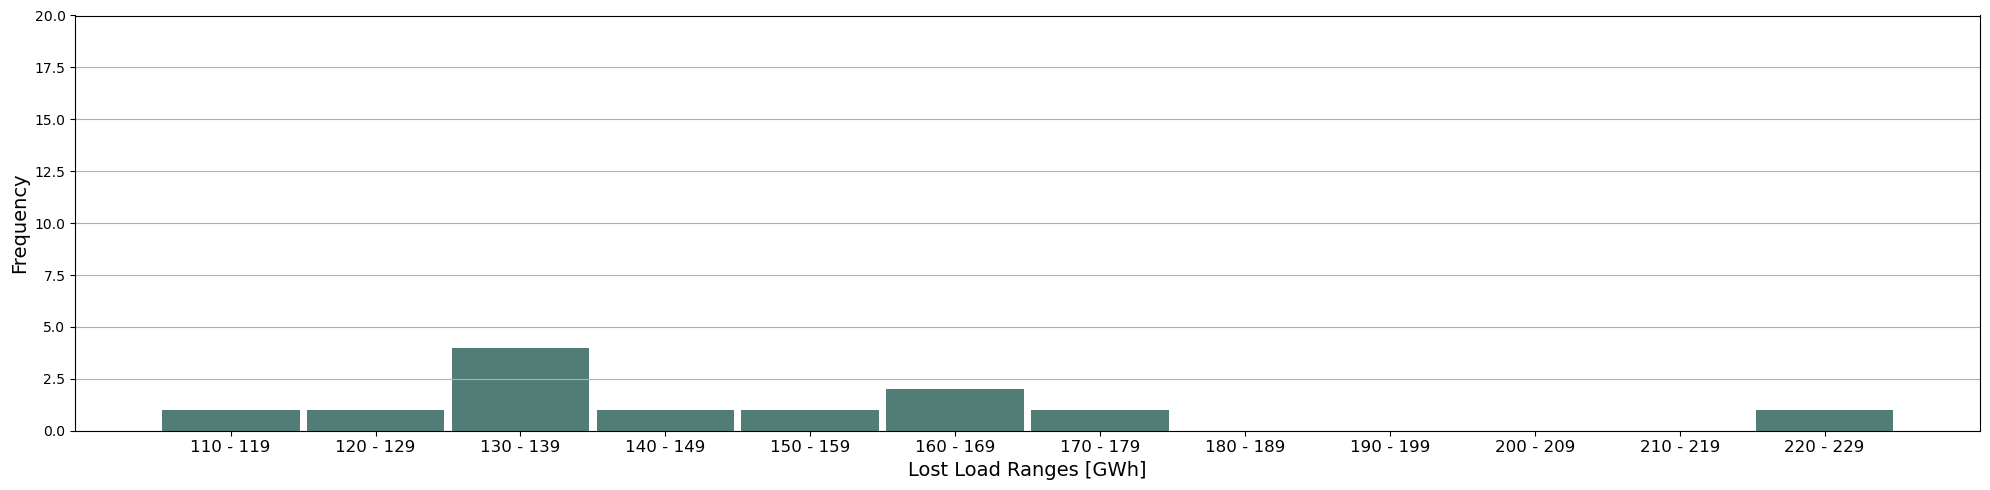

In [ ]:
# sorted_keys = sorted(all_ranges, key=lambda x: int(x.split(' - ')[0]))

# # Extract counts for each sorted range
# sorted_counts = [LL_ranges[key] for key in sorted_keys]

# # Creating the plot
# plt.figure(figsize=(20, 5))
# plt.bar(sorted_keys, sorted_counts, color=teal3, width=0.95)
# plt.xlabel('Lost Load Ranges [GWh]', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.ylim(0,20)
# plt.grid(axis='y')
# #plt.title('Distribution of Loss Load Values by Range')
# plt.xticks(rotation=0, fontsize=12)  # Rotate the range labels for better readability
# plt.tight_layout()  # Adjust layout to make room for label rotation

# # Show the plot
# plt.show()

<Figure size 1000x500 with 0 Axes>

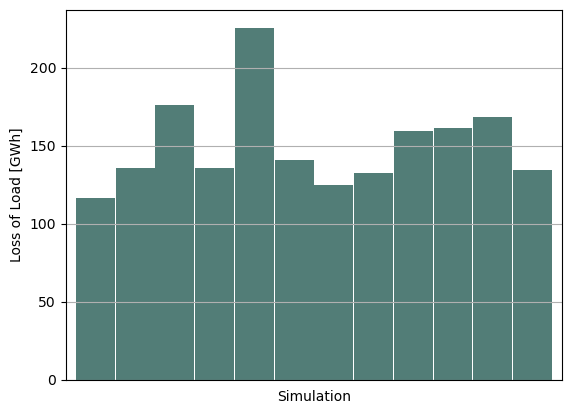

In [ ]:
# LL_df_sorted = LL_df.sort_values(by=LL_df.columns[0], ascending=False)
# plt.figure(figsize=(10,5))
# ax = LL_df.plot(kind='bar', color=teal3, width=0.98, legend=False)
# plt.xlabel('Simulation')
# # current_xticks = ax.get_xticks()
# # new_labels = [str(i+1) for i in range(n_simulations)]
# # plt.xticks(current_xticks,new_labels,rotation=0)
# plt.xticks([])
# plt.ylabel('Loss of Load [GWh]')
# plt.grid(axis='y')
# plt.show()